# MCMC Fitting Test

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import corner

from lltypeiip.dusty import DustyRunner, fit_grid_to_sed, plot_best_fit_dusty_model
from lltypeiip.sed import build_multi_epoch_seds_from_tail, plot_sed
from lltypeiip.inference import run_mcmc_for_sed
from lltypeiip.config import config
from lltypeiip.photometry import get_wise_lc_data, get_ztf_lc_data, convert_ZTF_mag_mJy, plot_combined_lc

from alerce.core import Alerce

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup DUSTY Runner

Create a DustyRunner instance using the config defaults.

In [22]:
# DUSTY configuration from package defaults
dusty_file_dir = config.dusty.dusty_file_dir
workdir = "../dusty_runs/mcmc_test_workdir"

runner = DustyRunner(
    base_workdir=workdir,
    dusty_file_dir=dusty_file_dir,
    dust_type="silicate",
    shell_thickness=2.0,
)

print(f"DUSTY binary: {dusty_file_dir}")
print(f"Working directory: {workdir}")

DUSTY binary: /home/cal/analam/Documents/dusty/releaseV2
Working directory: ../dusty_runs/mcmc_test_workdir


## Load Light Curve Data

Get ZTF and WISE light curves for sample object `ZTF22abtspsw`.

In [23]:
alerce = Alerce()
oid = 'ZTF22abtspsw'

wise_resdict = get_wise_lc_data(oid)
ztf_resdict = get_ztf_lc_data(oid, alerce, doLC=False, doStamps=False, add_forced=True)
ztf_resdict = convert_ZTF_mag_mJy(ztf_resdict, forced=True)

Saved ztf_resdict for ZTF22abtspsw to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce


/home/cal/analam/Documents/LL_typeIIP/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/photometry/plotting.py:651: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/photometry/plotting.py:198: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  # Find first detection with a valid stamp


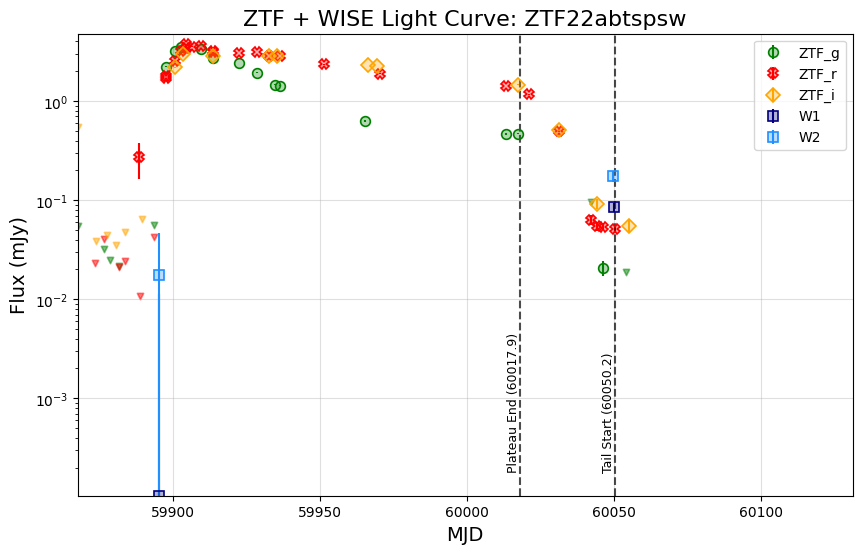

In [24]:
plot_combined_lc(ztf_resdict, wise_resdict, oid=oid, 
                 ztf_flux=True, mode="overlay", scale_wise=True, baseline_ref="wise_parity",
                 ref_band="r", logy=True, mark_plateau_end=True, mark_tail_start=True);

## Build Multi-Epoch SEDs

Build SEDs from the tail phase (requiring WISE detections).

/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/photometry/plotting.py:651: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/photometry/plotting.py:198: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  # Find first detection with a valid stamp



SED at MJD0 = 60049.87
  ZTF_g: Δt=-3.68 d
  ZTF_r: Δt=+0.34 d
  W1: Δt=+0.03 d
  W2: Δt=-0.03 d
{'ztf_flux': True, 'mode': 'overlay', 'scale_wise': True, 'baseline_ref': 'wise_parity', 'ref_band': 'r', 'logy': True, 'labels': False, 'mark_plateau_end': True, 'mark_tail_start': True}


/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/sed/plotting.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  for line in ax.lines:


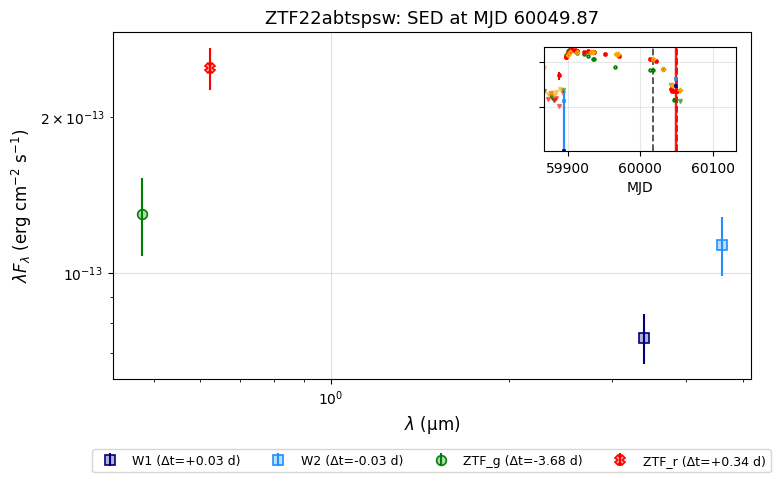

In [25]:
seds = build_multi_epoch_seds_from_tail(ztf_resdict, wise_resdict, require_wise_detection=True)

for sed in seds:
    print(f"\nSED at MJD0 = {sed['mjd']:.2f}")
    for b, dt_label in zip(sed["bands"], sed["dt_labels"]):
        print(f"  {b}: {dt_label}")
    plot_sed(
        sed,
        y_mode="Flam",
        logx=True,
        logy=True,
        legend_outside=True,
        inset_lc={
            "ztf_resdict": ztf_resdict,
            "wise_resdict": wise_resdict,
            "oid": oid,
        },
        inset_options={
            "mark_plateau_end": True,
            "mark_tail_start": True,
        }
    );

## Fit DUSTY Grid to SED

Fit pre-computed DUSTY grid models to the first SED.

In [26]:
sed = seds[0]
grid_dir = "../dusty_runs/silicate_tau_0.55um_fixed_thick_grid"

df = fit_grid_to_sed(grid_dir, sed, y_mode="Flam", use_weights=True)
print("Top 3 grid fits:")
df.sort_values(by="chi2_red").head(3)

Top 3 grid fits:


/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/dusty/scaling.py:198: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df._models = model_map


,folder,oid,tstar,tdust,tau,scale,chi2,dof,chi2_red
2601,../dusty_runs/silicate_tau_0.55um_fixed_thick_...,ZTF22abtspsw,7250.0,650.0,3.5,1.004299e-12,0.309363,3,0.103121
2433,../dusty_runs/silicate_tau_0.55um_fixed_thick_...,ZTF22abtspsw,7000.0,650.0,3.5,9.937835e-13,0.325603,3,0.108534
2769,../dusty_runs/silicate_tau_0.55um_fixed_thick_...,ZTF22abtspsw,7500.0,650.0,3.5,1.015402e-12,0.432783,3,0.144261


## Plot Best Grid Fits

Visualize the top grid model fits overlaid on the SED data.

/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/photometry/plotting.py:651: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/photometry/plotting.py:198: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  # Find first detection with a valid stamp
/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/sed/plotting.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  for line in ax.lines:
/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/dusty/plotting.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


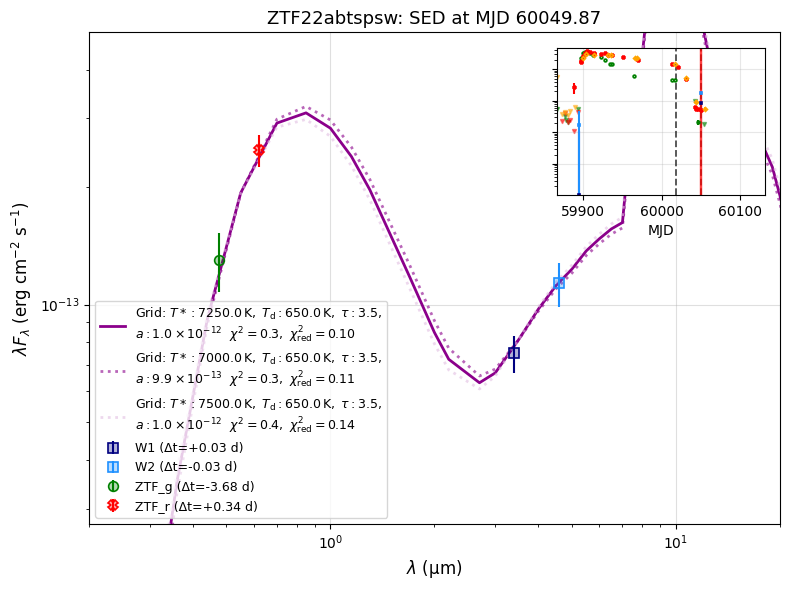

In [35]:
plot_best_fit_dusty_model(sed, df, y_mode="Flam", top_n=3, keep_sed_limits=True, inset_lc=True, ztf_resdict=ztf_resdict, wise_resdict=wise_resdict)

## Testing Different MCMC Fitting Methods

Run MCMC fits with different priors. First a **"data-driven"** approach with broad priors, second priors **"anchored"** around the grid best fit, third, a **"mixture"/hybrid** approach with a mixture setting of 0.3 (*p = 0.3 * anchored + (1-0.3) * data-driven*).

I run all fitting methods with `sweep`.

```
!python -m lltypeiip.inference.run_sed_mcmc ZTF22abtspsw --sweep --nsteps 1500 --burnin 300 --nwalkers 32 --ncores 8 --mp fork
```

In [28]:
# results = run_mcmc_for_sed(
#     sed=sed,
#     grid_df=df,
#     dusty_file_dir=dusty_file_dir,
#     workdir=workdir,
#     dust_type="silicate",
#     shell_thickness=2.0,
#     nwalkers=16,  
#     nsteps=200,       
#     burn_in=50,
#     y_mode="Flam",
#     n_cores=4,
#     random_seed=42,
# )

# print("MCMC completed!")
# print(f"Samples shape: {results['samples'].shape}")
# print(f"Log probability shape: {results['log_prob'].shape}")

In [29]:
outdir = Path(config.paths.mcmc_results_dir) / oid

files = {
    "data": outdir / f"mcmc_{oid}_data.npz",
    "anchored": outdir / f"mcmc_{oid}_anchored.npz",
    "mixture": outdir / f"mcmc_{oid}_mixture.npz",
}

def q16_50_84(x):
    q = np.quantile(x, [0.16, 0.5, 0.84])
    return q[1], q[0], q[2]  # median, low, high

params = ["tstar", "tdust", "tau", "a"]

print("Mode      logP_med   tstar_med    tdust_med     tau_med       a_med       N_samples")
print("-"*80)
for mode, fp in files.items():
    d = np.load(fp, allow_pickle=True)
    logp_med = np.median(d["log_prob"])
    meds = [q16_50_84(d[p])[0] for p in params]
    print(f"{mode:8s}  {logp_med:9.2f}  " + "  ".join(f"{m:10.3g}" for m in meds) + f"{len(d['log_prob']):12d}")

print(" ")

for mode, fp in files.items():
    d = np.load(fp, allow_pickle=True)
    chi2_med = -2.0 * np.median(d["log_prob"])
    print(mode, "chi2_median ~", chi2_med)

Mode      logP_med   tstar_med    tdust_med     tau_med       a_med       N_samples
--------------------------------------------------------------------------------
data          -1.99    7.27e+03         637         3.3    9.81e-13       38400
anchored      -1.73     7.4e+03         638        3.42    1.02e-12       38400
mixture       -1.88    7.28e+03         645        3.34    9.92e-13       38400
 
data chi2_median ~ 3.9808403424222423
anchored chi2_median ~ 3.4593539419112544
mixture chi2_median ~ 3.7649693464333347


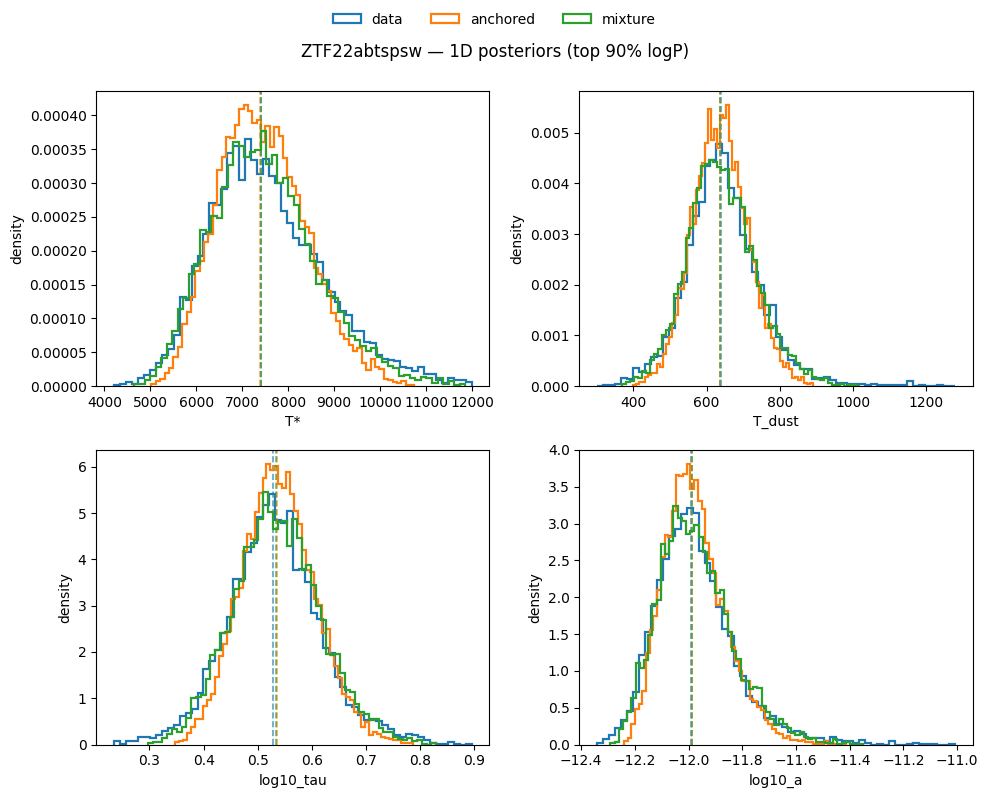

In [30]:
data_npz    = np.load(outdir / f"mcmc_{oid}_data.npz", allow_pickle=True)
anch_npz    = np.load(outdir / f"mcmc_{oid}_anchored.npz", allow_pickle=True)
mix_npz     = np.load(outdir / f"mcmc_{oid}_mixture.npz", allow_pickle=True)

def top_quantile_samples(npz, keep_frac=0.9, max_points=30000, seed=0):
    s  = npz["samples"]
    lp = npz["log_prob"]
    m = np.isfinite(lp)
    s, lp = s[m], lp[m]

    cut = np.quantile(lp, 1.0 - keep_frac) 
    s = s[lp >= cut]

    if len(s) > max_points:
        rng = np.random.default_rng(seed)
        idx = rng.choice(len(s), size=max_points, replace=False)
        s = s[idx]
    return s

keep_frac = .9


S = {
    "data":    top_quantile_samples(data_npz, keep_frac=keep_frac),
    "anchored":top_quantile_samples(anch_npz, keep_frac=keep_frac),
    "mixture": top_quantile_samples(mix_npz,  keep_frac=keep_frac),
}

param_names = ["T*", "T_dust", "log10_tau", "log10_a"]
modes = ["data", "anchored", "mixture"]
colors = {"data": "tab:blue", "anchored": "tab:orange", "mixture": "tab:green"}

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for j, ax in enumerate(axes):
    for mode in modes:
        x = S[mode][:, j]
        ax.hist(x, bins=60, density=True, histtype="step",
                label=mode, color=colors[mode], linewidth=1.6)
        ax.axvline(np.median(x), ls="--", alpha=0.7, color=colors[mode], linewidth=1.2)

    ax.set_xlabel(param_names[j])
    ax.set_ylabel("density")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)

fig.suptitle(f"{oid} — 1D posteriors (top {int(keep_frac*100)}% logP)", y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

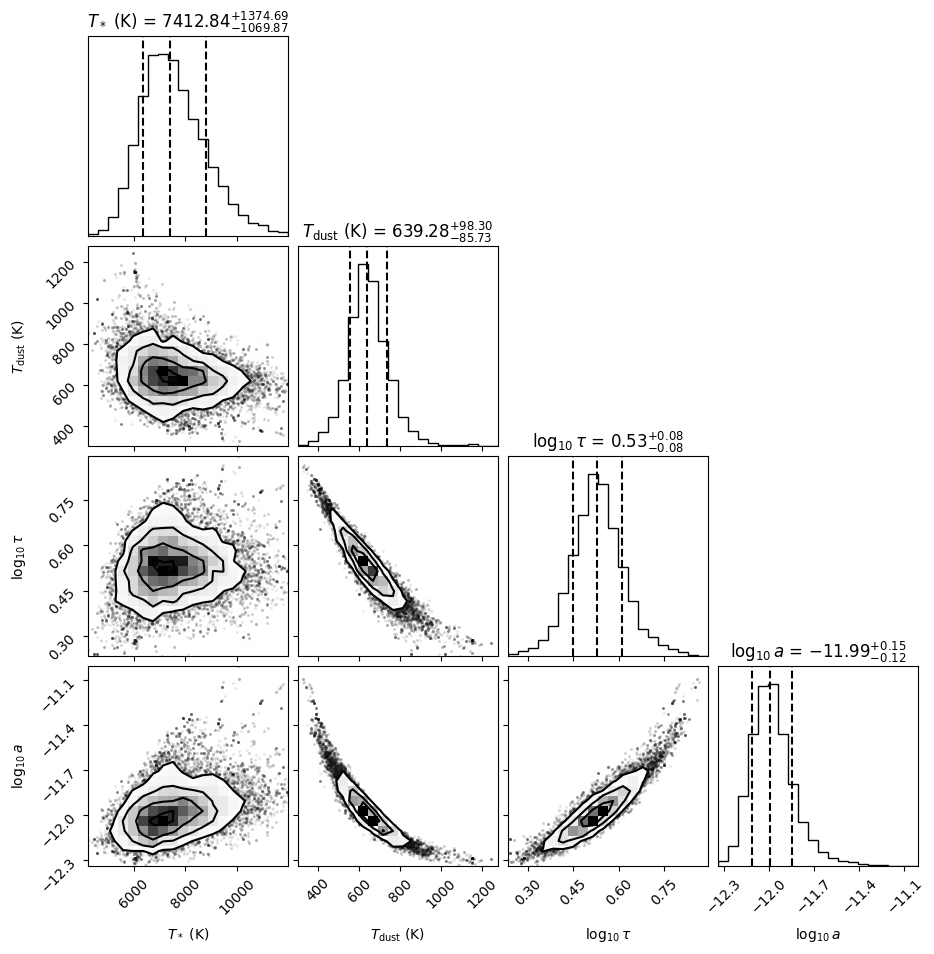

In [31]:
samples = data_npz["samples"]
logp = data_npz["log_prob"]

m = np.isfinite(logp)
samples = samples[m]
logp = logp[m]

keep_frac = 0.90   # try 0.90 or 0.95
cut = np.quantile(logp, 1.0 - keep_frac)
samples_core = samples[logp >= cut]

samples = samples_core
fig = corner.corner(
    samples,
    labels=[r"$T_*$ (K)", r"$T_\mathrm{dust}$ (K)", r"$\log_{10}\tau$", r"$\log_{10} a$"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    # bins=50,
    # smooth=0.3,
    # smooth1d=0.3,
)

## Plot MCMC Best Fit

Overlay the MCMC best-fit model on the SED along with grid fits.

/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/photometry/plotting.py:651: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/photometry/plotting.py:198: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  # Find first detection with a valid stamp
/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/sed/plotting.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  for line in ax.lines:
/home/cal/analam/Documents/LL_typeIIP/src/lltypeiip/dusty/plotting.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


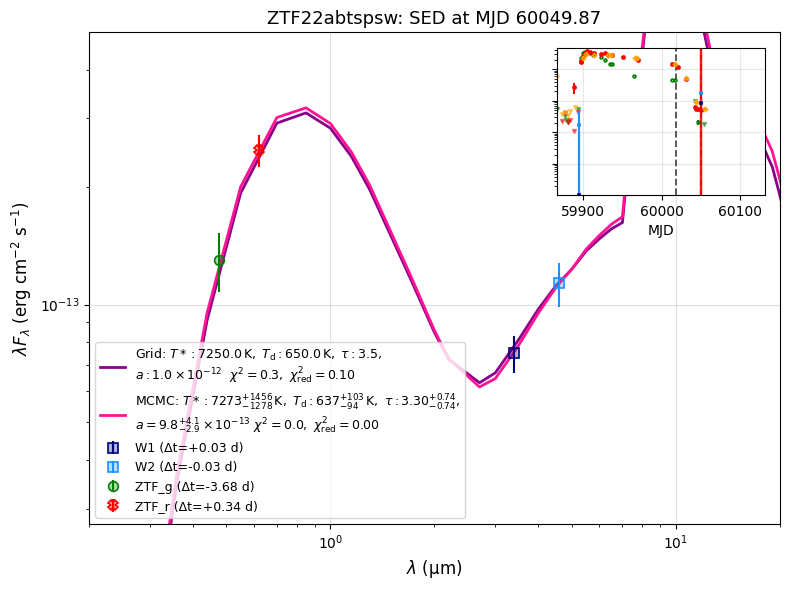

In [32]:
plot_best_fit_dusty_model(
    sed=sed,
    df=df,
    y_mode="Flam",
    top_n=1,
    keep_sed_limits=True,
    mcmc_results=data_npz,
    dusty_runner=runner,
    mcmc_sample_mode="map",
    inset_lc=True, 
    ztf_resdict=ztf_resdict, 
    wise_resdict=wise_resdict
)